# Download Dataset (175GB)

In [ ]:
# !wget -i splits/kitti_archives_to_download.txt -P kitti_data/

# cd kitti_data
# unzip "*.zip"
# cd ..

# Import Libraries

In [1]:
# from __future__ import absolute_import, division, print_function


import numpy as np

import torch
import torch.nn.functional as F

import time
import json
import os

from tensorboardX import SummaryWriter

# from utils import *
# from kitti_utils import *
# from layers import *

import networks
from IPython import embed

# Hyperparameters

In [2]:
batch_size = 4
num_epochs = 20
lr = 1e-4

device = torch.device("cuda")
num_workers = 2
split = "eigen_full"
data_path = os.path.join("kitti_data")
height = 192
width = 640
min_depth = 0.1
max_depth = 100
frame_ids = [0, -1, 1]
scales=range(4)
num_scales = 4
disparity_smoothness = 1e-3

# Datasets

In [3]:
"""https://github.com/nianticlabs/monodepth2/blob/master/kitti_utils.py"""
import os
import numpy as np
from collections import Counter

def load_velodyne_points(filename):
    """Load 3D point cloud from KITTI file format
    (adapted from https://github.com/hunse/kitti)
    """
    points = np.fromfile(filename, dtype=np.float32).reshape(-1, 4)
    points[:, 3] = 1.0  # homogeneous
    return points


def read_calib_file(path):
    """Read KITTI calibration file
    (from https://github.com/hunse/kitti)
    """
    float_chars = set("0123456789.e+- ")
    data = {}
    with open(path, 'r') as f:
        for line in f.readlines():
            key, value = line.split(':', 1)
            value = value.strip()
            data[key] = value
            if float_chars.issuperset(value):
                # try to cast to float array
                try:
                    data[key] = np.array(list(map(float, value.split(' '))))
                except ValueError:
                    # casting error: data[key] already eq. value, so pass
                    pass

    return data


def sub2ind(matrixSize, rowSub, colSub):
    """Convert row, col matrix subscripts to linear indices
    """
    m, n = matrixSize
    return rowSub * (n-1) + colSub - 1


def generate_depth_map(calib_dir, velo_filename, cam=2, vel_depth=False):
    """Generate a depth map from velodyne data
    """
    # load calibration files
    cam2cam = read_calib_file(os.path.join(calib_dir, 'calib_cam_to_cam.txt'))
    velo2cam = read_calib_file(os.path.join(calib_dir, 'calib_velo_to_cam.txt'))
    velo2cam = np.hstack((velo2cam['R'].reshape(3, 3), velo2cam['T'][..., np.newaxis]))
    velo2cam = np.vstack((velo2cam, np.array([0, 0, 0, 1.0])))

    # get image shape
    im_shape = cam2cam["S_rect_02"][::-1].astype(np.int32)

    # compute projection matrix velodyne->image plane
    R_cam2rect = np.eye(4)
    R_cam2rect[:3, :3] = cam2cam['R_rect_00'].reshape(3, 3)
    P_rect = cam2cam['P_rect_0'+str(cam)].reshape(3, 4)
    P_velo2im = np.dot(np.dot(P_rect, R_cam2rect), velo2cam)

    # load velodyne points and remove all behind image plane (approximation)
    # each row of the velodyne data is forward, left, up, reflectance
    velo = load_velodyne_points(velo_filename)
    velo = velo[velo[:, 0] >= 0, :]

    # project the points to the camera
    velo_pts_im = np.dot(P_velo2im, velo.T).T
    velo_pts_im[:, :2] = velo_pts_im[:, :2] / velo_pts_im[:, 2][..., np.newaxis]

    if vel_depth:
        velo_pts_im[:, 2] = velo[:, 0]

    # check if in bounds
    # use minus 1 to get the exact same value as KITTI matlab code
    velo_pts_im[:, 0] = np.round(velo_pts_im[:, 0]) - 1
    velo_pts_im[:, 1] = np.round(velo_pts_im[:, 1]) - 1
    val_inds = (velo_pts_im[:, 0] >= 0) & (velo_pts_im[:, 1] >= 0)
    val_inds = val_inds & (velo_pts_im[:, 0] < im_shape[1]) & (velo_pts_im[:, 1] < im_shape[0])
    velo_pts_im = velo_pts_im[val_inds, :]

    # project to image
    depth = np.zeros((im_shape[:2]))
    depth[velo_pts_im[:, 1].astype(np.int), velo_pts_im[:, 0].astype(np.int)] = velo_pts_im[:, 2]

    # find the duplicate points and choose the closest depth
    inds = sub2ind(depth.shape, velo_pts_im[:, 1], velo_pts_im[:, 0])
    dupe_inds = [item for item, count in Counter(inds).items() if count > 1]
    for dd in dupe_inds:
        pts = np.where(inds == dd)[0]
        x_loc = int(velo_pts_im[pts[0], 0])
        y_loc = int(velo_pts_im[pts[0], 1])
        depth[y_loc, x_loc] = velo_pts_im[pts, 2].min()
    depth[depth < 0] = 0

    return depth

In [4]:
import os
import random
import numpy as np
import copy
from PIL import Image  # using pillow-simd for increased speed
import PIL.Image as pil

import skimage.transform

import torch
import torch.utils.data as data
from torchvision import transforms

def pil_loader(path):
    # open path as file to avoid ResourceWarning
    # (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

class MonoDataset(data.Dataset):
    """Superclass for monocular dataloaders

    Args:
        data_path
        filenames
        height
        width
        frame_idxs
        num_scales
        is_train
        img_ext
    """
    def __init__(self,
                 data_path,
                 filenames,
                 height,
                 width,
                 frame_idxs,
                 num_scales,
                 is_train=False,
                 img_ext='.png'):
        super(MonoDataset, self).__init__()

        self.data_path = data_path
        self.filenames = filenames
        self.height = height
        self.width = width
        self.num_scales = num_scales
        self.interp = Image.ANTIALIAS

        self.frame_idxs = frame_idxs

        self.is_train = is_train
        self.img_ext = img_ext

        self.loader = pil_loader
        self.to_tensor = transforms.ToTensor()

        # We need to specify augmentations differently in newer versions of torchvision.
        # We first try the newer tuple version; if this fails we fall back to scalars
        try:
            self.brightness = (0.8, 1.2)
            self.contrast = (0.8, 1.2)
            self.saturation = (0.8, 1.2)
            self.hue = (-0.1, 0.1)
            transforms.ColorJitter(self.brightness, self.contrast, self.saturation, self.hue)
        except TypeError:
            self.brightness = 0.2
            self.contrast = 0.2
            self.saturation = 0.2
            self.hue = 0.1

        self.resize = {}
        for i in range(self.num_scales):
            s = 2 ** i
            self.resize[i] = transforms.Resize((self.height // s, self.width // s),
                                               interpolation=self.interp)

        self.load_depth = self.check_depth()
        
        self.K = np.array([[0.58, 0, 0.5, 0],
                           [0, 1.92, 0.5, 0],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]], dtype=np.float32)

        self.full_res_shape = (1242, 375)
        self.side_map = {"2": 2, "3": 3, "l": 2, "r": 3}

    def preprocess(self, inputs, color_aug):
        """Resize colour images to the required scales and augment if required

        We create the color_aug object in advance and apply the same augmentation to all
        images in this item. This ensures that all images input to the pose network receive the
        same augmentation.
        """
        for k in list(inputs):
            frame = inputs[k]
            if "color" in k:
                n, im, i = k
                for i in range(self.num_scales):
                    inputs[(n, im, i)] = self.resize[i](inputs[(n, im, i - 1)])

        for k in list(inputs):
            f = inputs[k]
            if "color" in k:
                n, im, i = k
                inputs[(n, im, i)] = self.to_tensor(f)
                inputs[(n + "_aug", im, i)] = self.to_tensor(color_aug(f))

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        """Returns a single training item from the dataset as a dictionary.

        Values correspond to torch tensors.
        Keys in the dictionary are either strings or tuples:

            ("color", <frame_id>, <scale>)          for raw colour images,
            ("color_aug", <frame_id>, <scale>)      for augmented colour images,
            ("K", scale) or ("inv_K", scale)        for camera intrinsics,
            "stereo_T"                              for camera extrinsics, and
            "depth_gt"                              for ground truth depth maps.

        <frame_id> is either:
            an integer (e.g. 0, -1, or 1) representing the temporal step relative to 'index',
        or
            "s" for the opposite image in the stereo pair.

        <scale> is an integer representing the scale of the image relative to the fullsize image:
            -1      images at native resolution as loaded from disk
            0       images resized to (self.width,      self.height     )
            1       images resized to (self.width // 2, self.height // 2)
            2       images resized to (self.width // 4, self.height // 4)
            3       images resized to (self.width // 8, self.height // 8)
        """
        inputs = {}

        do_color_aug = self.is_train and random.random() > 0.5
        do_flip = self.is_train and random.random() > 0.5

        line = self.filenames[index].split()
        folder = line[0]

        if len(line) == 3:
            frame_index = int(line[1])
        else:
            frame_index = 0

        if len(line) == 3:
            side = line[2]
        else:
            side = None

        for i in self.frame_idxs:
            if i == "s":
                other_side = {"r": "l", "l": "r"}[side]
                inputs[("color", i, -1)] = self.get_color(folder, frame_index, other_side, do_flip)
            else:
                inputs[("color", i, -1)] = self.get_color(folder, frame_index + i, side, do_flip)

        # adjusting intrinsics to match each scale in the pyramid
        for scale in range(self.num_scales):
            K = self.K.copy()

            K[0, :] *= self.width // (2 ** scale)
            K[1, :] *= self.height // (2 ** scale)

            inv_K = np.linalg.pinv(K)

            inputs[("K", scale)] = torch.from_numpy(K)
            inputs[("inv_K", scale)] = torch.from_numpy(inv_K)

        if do_color_aug:
            color_aug = transforms.ColorJitter(self.brightness, self.contrast, self.saturation, self.hue)
        else:
            color_aug = (lambda x: x)

        self.preprocess(inputs, color_aug)

        for i in self.frame_idxs:
            del inputs[("color", i, -1)]
            del inputs[("color_aug", i, -1)]

        if self.load_depth:
            depth_gt = self.get_depth(folder, frame_index, side, do_flip)
            inputs["depth_gt"] = np.expand_dims(depth_gt, 0)
            inputs["depth_gt"] = torch.from_numpy(inputs["depth_gt"].astype(np.float32))

        if "s" in self.frame_idxs:
            stereo_T = np.eye(4, dtype=np.float32)
            baseline_sign = -1 if do_flip else 1
            side_sign = -1 if side == "l" else 1
            stereo_T[0, 3] = side_sign * baseline_sign * 0.1

            inputs["stereo_T"] = torch.from_numpy(stereo_T)

        return inputs

    def get_image_path(self, folder, frame_index, side):
        f_str = "{:010d}{}".format(frame_index, self.img_ext)
        image_path = os.path.join(
            self.data_path, folder, "image_0{}/data".format(self.side_map[side]), f_str)
        return image_path
    
    def get_color(self, folder, frame_index, side, do_flip):
        color = self.loader(self.get_image_path(folder, frame_index, side))

        if do_flip:
            color = color.transpose(pil.FLIP_LEFT_RIGHT)

        return color
    
    def check_depth(self):
        line = self.filenames[0].split()
        scene_name = line[0]
        frame_index = int(line[1])

        velo_filename = os.path.join(
            self.data_path,
            scene_name,
            "velodyne_points/data/{:010d}.bin".format(int(frame_index)))

        return os.path.isfile(velo_filename)

    def get_depth(self, folder, frame_index, side, do_flip):
        calib_path = os.path.join(self.data_path, folder.split("/")[0])

        velo_filename = os.path.join(
            self.data_path,
            folder,
            "velodyne_points/data/{:010d}.bin".format(int(frame_index)))

        depth_gt = generate_depth_map(calib_path, velo_filename, self.side_map[side])
        depth_gt = skimage.transform.resize(
            depth_gt, self.full_res_shape[::-1], order=0, preserve_range=True, mode='constant')

        if do_flip:
            depth_gt = np.fliplr(depth_gt)

        return depth_gt

In [5]:
# import datasets
from torch.utils.data import DataLoader

def readlines(filename):
    """Read all the lines in a text file and return as a list
    """
    with open(filename, 'r') as f:
        lines = f.read().splitlines()
    return lines

# datasets_dict = {"kitti": datasets.KITTIRAWDataset,
#                  "kitti_odom": datasets.KITTIOdomDataset}
# dataset = datasets_dict["kitti"]

fpath = os.path.join("splits", split, "{}_files.txt")

train_filenames = readlines(fpath.format("train"))
val_filenames = readlines(fpath.format("val"))
img_ext = '.png'# if self.opt.png else '.jpg'

num_train_samples = len(train_filenames)
num_total_steps = num_train_samples // batch_size * num_epochs


# Dataset
# train_dataset = dataset(
train_dataset = MonoDataset(
    data_path, train_filenames, height, width,
    frame_ids, 4, is_train=True, img_ext=img_ext)

# val_dataset = dataset(
val_dataset = MonoDataset(
    data_path, val_filenames, height, width,
    frame_ids, 4, is_train=False, img_ext=img_ext)

# Dataloader
train_loader = DataLoader(
    train_dataset, batch_size, True,
    num_workers=num_workers, pin_memory=True, drop_last=True)

val_loader = DataLoader(
    val_dataset, batch_size, True,
    num_workers=num_workers, pin_memory=True, drop_last=True)

val_iter = iter(val_loader)

/home/user0424sj/venv/lib/python3.6/site-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


## Model
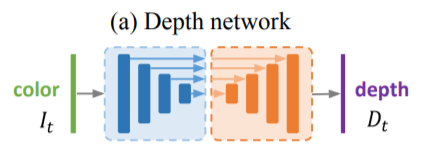

Overall structur: U-Net (one type of AutoEncoder)

Encoder uses Resnet

In [6]:
"""Ref: https://github.com/nianticlabs/monodepth2/blob/master/networks/resnet_encoder.py"""
import numpy as np

import torch
import torch.nn as nn
import torchvision.models as models
import torch.utils.model_zoo as model_zoo

class ResNetMultiImageInput(models.ResNet):
    """Constructs a resnet model with varying number of input images.
    Adapted from https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
    """
    def __init__(self, block, layers, num_classes=1000, num_input_images=1):
        super(ResNetMultiImageInput, self).__init__(block, layers)
        self.inplanes = 64
        self.conv1 = nn.Conv2d(
            num_input_images * 3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

def resnet_multiimage_input(num_layers, pretrained=False, num_input_images=1):
    """Constructs a ResNet model.
    Args:
        num_layers (int): Number of resnet layers. Must be 18 or 50
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        num_input_images (int): Number of frames stacked as input
    """
    assert num_layers in [18, 50], "Can only run with 18 or 50 layer resnet"
    blocks = {18: [2, 2, 2, 2], 50: [3, 4, 6, 3]}[num_layers]
    block_type = {18: models.resnet.BasicBlock, 50: models.resnet.Bottleneck}[num_layers]
    model = ResNetMultiImageInput(block_type, blocks, num_input_images=num_input_images)

    if pretrained:
        loaded = model_zoo.load_url(models.resnet.model_urls['resnet{}'.format(num_layers)])
        loaded['conv1.weight'] = torch.cat(
            [loaded['conv1.weight']] * num_input_images, 1) / num_input_images
        model.load_state_dict(loaded)
    return model

class ResnetEncoder(nn.Module):
    """Pytorch module for a resnet encoder
    """
    def __init__(self, num_layers=18, pretrained="pretrained", num_input_images=1):
        super(ResnetEncoder, self).__init__()

        self.num_ch_enc = np.array([64, 64, 128, 256, 512])

        resnets = {18: models.resnet18,
                   34: models.resnet34,
                   50: models.resnet50,
                   101: models.resnet101,
                   152: models.resnet152}

        if num_layers not in resnets:
            raise ValueError("{} is not a valid number of resnet layers".format(num_layers))

        if num_input_images > 1:
            self.encoder = resnet_multiimage_input(num_layers, pretrained, num_input_images)
        else:
            self.encoder = resnets[num_layers](pretrained)

        if num_layers > 34:
            self.num_ch_enc[1:] *= 4

    def forward(self, input_image):
        self.features = []
        x = (input_image - 0.45) / 0.225
        x = self.encoder.conv1(x)
        x = self.encoder.bn1(x)
        self.features.append(self.encoder.relu(x))
        self.features.append(self.encoder.layer1(self.encoder.maxpool(self.features[-1])))
        self.features.append(self.encoder.layer2(self.features[-1]))
        self.features.append(self.encoder.layer3(self.features[-1]))
        self.features.append(self.encoder.layer4(self.features[-1]))

        return self.features

In [7]:
"""Ref: https://github.com/nianticlabs/monodepth2/blob/master/networks/depth_decoder.py"""
from collections import OrderedDict

def upsample(x):
    """Upsample input tensor by a factor of 2
    """
    return F.interpolate(x, scale_factor=2, mode="nearest")

class ConvBlock(nn.Module):
    """Layer to perform a convolution followed by ELU
    """
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = Conv3x3(in_channels, out_channels)
        self.nonlin = nn.ELU(inplace=True)

    def forward(self, x):
        out = self.conv(x)
        out = self.nonlin(out)
        return out

class Conv3x3(nn.Module):
    """Layer to pad and convolve input
    """
    def __init__(self, in_channels, out_channels, use_refl=True):
        super(Conv3x3, self).__init__()

        if use_refl:
            self.pad = nn.ReflectionPad2d(1)
        else:
            self.pad = nn.ZeroPad2d(1)
        self.conv = nn.Conv2d(int(in_channels), int(out_channels), 3)

    def forward(self, x):
        out = self.pad(x)
        out = self.conv(out)
        return out

class DepthDecoder(nn.Module):
    def __init__(self, num_ch_enc=np.array([64, 64, 128, 256, 512]), scales=range(4), num_output_channels=1, use_skips=True):
        super(DepthDecoder, self).__init__()

        self.num_output_channels = num_output_channels
        self.use_skips = use_skips
        self.upsample_mode = 'nearest'
        self.scales = scales

        self.num_ch_enc = num_ch_enc
        self.num_ch_dec = np.array([16, 32, 64, 128, 256])

        # decoder
        self.convs = OrderedDict()
        for i in range(4, -1, -1):
            # upconv_0
            num_ch_in = self.num_ch_enc[-1] if i == 4 else self.num_ch_dec[i + 1]
            num_ch_out = self.num_ch_dec[i]
            self.convs[("upconv", i, 0)] = ConvBlock(num_ch_in, num_ch_out)

            # upconv_1
            num_ch_in = self.num_ch_dec[i]
            if self.use_skips and i > 0:
                num_ch_in += self.num_ch_enc[i - 1]
            num_ch_out = self.num_ch_dec[i]
            self.convs[("upconv", i, 1)] = ConvBlock(num_ch_in, num_ch_out)

        for s in self.scales:
            self.convs[("dispconv", s)] = Conv3x3(self.num_ch_dec[s], self.num_output_channels)

        self.decoder = nn.ModuleList(list(self.convs.values()))
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_features):
        self.outputs = {}

        # decoder
        x = input_features[-1]
        for i in range(4, -1, -1):
            x = self.convs[("upconv", i, 0)](x)
            x = [upsample(x)]
            if self.use_skips and i > 0:
                x += [input_features[i - 1]]
            x = torch.cat(x, 1)
            x = self.convs[("upconv", i, 1)](x)
            if i in self.scales:
                self.outputs[("disp", i)] = self.sigmoid(self.convs[("dispconv", i)](x))

        return self.outputs

In [8]:
class PoseDecoder(nn.Module):
    def __init__(self, num_ch_enc, num_input_features, num_frames_to_predict_for=None, stride=1):
        super(PoseDecoder, self).__init__()

        self.num_ch_enc = num_ch_enc
        self.num_input_features = num_input_features

        if num_frames_to_predict_for is None:
            num_frames_to_predict_for = num_input_features - 1
        self.num_frames_to_predict_for = num_frames_to_predict_for

        self.convs = OrderedDict()
        self.convs[("squeeze")] = nn.Conv2d(self.num_ch_enc[-1], 256, 1)
        self.convs[("pose", 0)] = nn.Conv2d(num_input_features * 256, 256, 3, stride, 1)
        self.convs[("pose", 1)] = nn.Conv2d(256, 256, 3, stride, 1)
        self.convs[("pose", 2)] = nn.Conv2d(256, 6 * num_frames_to_predict_for, 1)

        self.relu = nn.ReLU()

        self.net = nn.ModuleList(list(self.convs.values()))

    def forward(self, input_features):
        last_features = [f[-1] for f in input_features]

        cat_features = [self.relu(self.convs["squeeze"](f)) for f in last_features]
        cat_features = torch.cat(cat_features, 1)

        out = cat_features
        for i in range(3):
            out = self.convs[("pose", i)](out)
            if i != 2:
                out = self.relu(out)

        out = out.mean(3).mean(2)

        out = 0.01 * out.view(-1, self.num_frames_to_predict_for, 1, 6)

        axisangle = out[..., :3]
        translation = out[..., 3:]

        return axisangle, translation

In [9]:
import torch.optim as optim

# Initialize models
depth_models = dict()
depth_models["encoder"] = ResnetEncoder().to(device)
depth_models["depth"] = DepthDecoder().to(device)

# share encoder
depth_models["pose"] = PoseDecoder(depth_models["encoder"].num_ch_enc, len(frame_ids)).to(device)

# separate encoder
# depth_models["pose_encoder"] = ResnetEncoder(num_input_images=len(frame_ids)).to(device)
# depth_models["pose"] = PoseDecoder(depth_models["pose_encoder"].num_ch_enc,
#                                    num_input_features=1,
#                                    num_frames_to_predict_for=2).to(device)

# Initialize optimizer and learning rate scheduler
parameters = []
parameters += list(depth_models["encoder"].parameters())
parameters += list(depth_models["depth"].parameters())
# parameters += list(depth_models["pose_encoder"].parameters())
parameters += list(depth_models["pose"].parameters())

optimizer = optim.Adam(parameters, lr=lr)
model_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, 15, 0.1)

# Loss
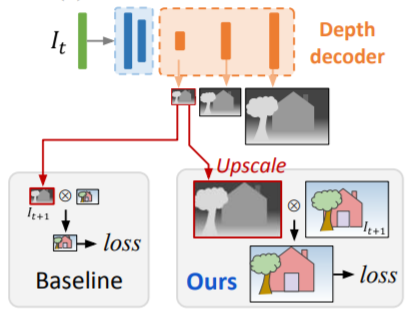

In [10]:
class SSIM(nn.Module):
    """Layer to compute the SSIM loss between a pair of images
    """
    def __init__(self):
        super(SSIM, self).__init__()
        self.mu_x_pool   = nn.AvgPool2d(3, 1)
        self.mu_y_pool   = nn.AvgPool2d(3, 1)
        self.sig_x_pool  = nn.AvgPool2d(3, 1)
        self.sig_y_pool  = nn.AvgPool2d(3, 1)
        self.sig_xy_pool = nn.AvgPool2d(3, 1)

        self.refl = nn.ReflectionPad2d(1)

        self.C1 = 0.01 ** 2
        self.C2 = 0.03 ** 2

    def forward(self, x, y):
        x = self.refl(x)
        y = self.refl(y)

        mu_x = self.mu_x_pool(x)
        mu_y = self.mu_y_pool(y)

        sigma_x  = self.sig_x_pool(x ** 2) - mu_x ** 2
        sigma_y  = self.sig_y_pool(y ** 2) - mu_y ** 2
        sigma_xy = self.sig_xy_pool(x * y) - mu_x * mu_y

        SSIM_n = (2 * mu_x * mu_y + self.C1) * (2 * sigma_xy + self.C2)
        SSIM_d = (mu_x ** 2 + mu_y ** 2 + self.C1) * (sigma_x + sigma_y + self.C2)

        return torch.clamp((1 - SSIM_n / SSIM_d) / 2, 0, 1)
    
def compute_reprojection_loss(pred, target, ssim=SSIM()):
    """Computes reprojection loss between a batch of predicted and target images
    """
    abs_diff = torch.abs(target - pred)
    l1_loss = abs_diff.mean(1, True)

    ssim_loss = ssim(pred, target).mean(1, True)
    reprojection_loss = 0.85 * ssim_loss + 0.15 * l1_loss

    return reprojection_loss

def get_smooth_loss(disp, img):
    """Computes the smoothness loss for a disparity image
    The color image is used for edge-aware smoothness
    """
    grad_disp_x = torch.abs(disp[:, :, :, :-1] - disp[:, :, :, 1:])
    grad_disp_y = torch.abs(disp[:, :, :-1, :] - disp[:, :, 1:, :])

    grad_img_x = torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:]), 1, keepdim=True)
    grad_img_y = torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]), 1, keepdim=True)

    grad_disp_x *= torch.exp(-grad_img_x)
    grad_disp_y *= torch.exp(-grad_img_y)

    return grad_disp_x.mean() + grad_disp_y.mean()

def compute_losses(inputs, outputs):
    """Compute the reprojection and smoothness losses for a minibatch
    """
    losses = {}
    total_loss = 0

    for scale in scales:
        loss = 0
        reprojection_losses = []

        source_scale = 0

        disp = outputs[("disp", scale)]
        color = inputs[("color", 0, scale)]
        target = inputs[("color", 0, source_scale)]

        for frame_id in frame_ids[1:]:
            pred = outputs[("color", frame_id, scale)]
            reprojection_losses.append(compute_reprojection_loss(pred, target))

        reprojection_losses = torch.cat(reprojection_losses, 1)

        reprojection_loss = reprojection_losses

        combined = reprojection_loss

        if combined.shape[1] == 1:
            to_optimise = combined
        else:
            to_optimise, idxs = torch.min(combined, dim=1)

        loss += to_optimise.mean()

        mean_disp = disp.mean(2, True).mean(3, True)
        norm_disp = disp / (mean_disp + 1e-7)
        smooth_loss = get_smooth_loss(norm_disp, color)

        loss += disparity_smoothness * smooth_loss / (2 ** scale)
        total_loss += loss
        losses["loss/{}".format(scale)] = loss

    total_loss /= num_scales
    losses["loss"] = total_loss
    return losses

def compute_depth_losses(inputs, outputs, losses):
    """Compute depth metrics, to allow monitoring during training

    This isn't particularly accurate as it averages over the entire batch,
    so is only used to give an indication of validation performance
    """
    depth_pred = outputs[("depth", 0, 0)]
    depth_pred = torch.clamp(F.interpolate(depth_pred, [375, 1242], mode="bilinear", align_corners=False), 1e-3, 80)
    depth_pred = depth_pred.detach()

    depth_gt = inputs["depth_gt"]
    mask = depth_gt > 0

    # garg/eigen crop
    crop_mask = torch.zeros_like(mask)
    crop_mask[:, :, 153:371, 44:1197] = 1
    mask = mask * crop_mask

    depth_gt = depth_gt[mask]
    depth_pred = depth_pred[mask]
    depth_pred *= torch.median(depth_gt) / torch.median(depth_pred)

    depth_pred = torch.clamp(depth_pred, min=1e-3, max=80)

    depth_errors = compute_depth_errors(depth_gt, depth_pred)

    depth_metric_names = ["de/abs_rel", "de/sq_rel", "de/rms", "de/log_rms", "da/a1", "da/a2", "da/a3"]
    
    for i, metric in enumerate(depth_metric_names):
        losses[metric] = np.array(depth_errors[i].cpu())

# Save Model

In [11]:
def save_model(models, epoch, optimizer):
    """Save model weights to disk
    """
    save_folder = os.path.join("models", "weights_{}".format(epoch))
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    for model_name, model in models.items():
        save_path = os.path.join(save_folder, "{}.pth".format(model_name))
        to_save = model.state_dict()
        if model_name == 'encoder':
            # save the sizes - these are needed at prediction time
            to_save['height'] = height
            to_save['width'] = width
#             to_save['use_stereo'] = use_stereo
        torch.save(to_save, save_path)

    save_path = os.path.join(save_folder, "{}.pth".format("adam"))
    torch.save(optimizer.state_dict(), save_path)

# Utils

In [12]:
"""https://github.com/nianticlabs/monodepth2/blob/master/layers.py"""
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


def disp_to_depth(disp, min_depth, max_depth):
    """Convert network's sigmoid output into depth prediction
    The formula for this conversion is given in the 'additional considerations'
    section of the paper.
    """
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return scaled_disp, depth


def transformation_from_parameters(axisangle, translation, invert=False):
    """Convert the network's (axisangle, translation) output into a 4x4 matrix
    """
    R = rot_from_axisangle(axisangle)
    t = translation.clone()

    if invert:
        R = R.transpose(1, 2)
        t *= -1

    T = get_translation_matrix(t)

    if invert:
        M = torch.matmul(R, T)
    else:
        M = torch.matmul(T, R)

    return M


def get_translation_matrix(translation_vector):
    """Convert a translation vector into a 4x4 transformation matrix
    """
    T = torch.zeros(translation_vector.shape[0], 4, 4).to(device=translation_vector.device)

    t = translation_vector.contiguous().view(-1, 3, 1)

    T[:, 0, 0] = 1
    T[:, 1, 1] = 1
    T[:, 2, 2] = 1
    T[:, 3, 3] = 1
    T[:, :3, 3, None] = t

    return T


def rot_from_axisangle(vec):
    """Convert an axisangle rotation into a 4x4 transformation matrix
    (adapted from https://github.com/Wallacoloo/printipi)
    Input 'vec' has to be Bx1x3
    """
    angle = torch.norm(vec, 2, 2, True)
    axis = vec / (angle + 1e-7)

    ca = torch.cos(angle)
    sa = torch.sin(angle)
    C = 1 - ca

    x = axis[..., 0].unsqueeze(1)
    y = axis[..., 1].unsqueeze(1)
    z = axis[..., 2].unsqueeze(1)

    xs = x * sa
    ys = y * sa
    zs = z * sa
    xC = x * C
    yC = y * C
    zC = z * C
    xyC = x * yC
    yzC = y * zC
    zxC = z * xC

    rot = torch.zeros((vec.shape[0], 4, 4)).to(device=vec.device)

    rot[:, 0, 0] = torch.squeeze(x * xC + ca)
    rot[:, 0, 1] = torch.squeeze(xyC - zs)
    rot[:, 0, 2] = torch.squeeze(zxC + ys)
    rot[:, 1, 0] = torch.squeeze(xyC + zs)
    rot[:, 1, 1] = torch.squeeze(y * yC + ca)
    rot[:, 1, 2] = torch.squeeze(yzC - xs)
    rot[:, 2, 0] = torch.squeeze(zxC - ys)
    rot[:, 2, 1] = torch.squeeze(yzC + xs)
    rot[:, 2, 2] = torch.squeeze(z * zC + ca)
    rot[:, 3, 3] = 1

    return rot


class ConvBlock(nn.Module):
    """Layer to perform a convolution followed by ELU
    """
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = Conv3x3(in_channels, out_channels)
        self.nonlin = nn.ELU(inplace=True)

    def forward(self, x):
        out = self.conv(x)
        out = self.nonlin(out)
        return out


class Conv3x3(nn.Module):
    """Layer to pad and convolve input
    """
    def __init__(self, in_channels, out_channels, use_refl=True):
        super(Conv3x3, self).__init__()

        if use_refl:
            self.pad = nn.ReflectionPad2d(1)
        else:
            self.pad = nn.ZeroPad2d(1)
        self.conv = nn.Conv2d(int(in_channels), int(out_channels), 3)

    def forward(self, x):
        out = self.pad(x)
        out = self.conv(out)
        return out


class BackprojectDepth(nn.Module):
    """Layer to transform a depth image into a point cloud
    """
    def __init__(self, batch_size, height, width):
        super(BackprojectDepth, self).__init__()

        self.batch_size = batch_size
        self.height = height
        self.width = width

        meshgrid = np.meshgrid(range(self.width), range(self.height), indexing='xy')
        self.id_coords = np.stack(meshgrid, axis=0).astype(np.float32)
        self.id_coords = nn.Parameter(torch.from_numpy(self.id_coords),
                                      requires_grad=False)

        self.ones = nn.Parameter(torch.ones(self.batch_size, 1, self.height * self.width),
                                 requires_grad=False)

        self.pix_coords = torch.unsqueeze(torch.stack(
            [self.id_coords[0].view(-1), self.id_coords[1].view(-1)], 0), 0)
        self.pix_coords = self.pix_coords.repeat(batch_size, 1, 1)
        self.pix_coords = nn.Parameter(torch.cat([self.pix_coords, self.ones], 1),
                                       requires_grad=False)

    def forward(self, depth, inv_K):
        cam_points = torch.matmul(inv_K[:, :3, :3], self.pix_coords)
        cam_points = depth.view(self.batch_size, 1, -1) * cam_points
        cam_points = torch.cat([cam_points, self.ones], 1)

        return cam_points


class Project3D(nn.Module):
    """Layer which projects 3D points into a camera with intrinsics K and at position T
    """
    def __init__(self, batch_size, height, width, eps=1e-7):
        super(Project3D, self).__init__()

        self.batch_size = batch_size
        self.height = height
        self.width = width
        self.eps = eps

    def forward(self, points, K, T):
        P = torch.matmul(K, T)[:, :3, :]

        cam_points = torch.matmul(P, points)

        pix_coords = cam_points[:, :2, :] / (cam_points[:, 2, :].unsqueeze(1) + self.eps)
        pix_coords = pix_coords.view(self.batch_size, 2, self.height, self.width)
        pix_coords = pix_coords.permute(0, 2, 3, 1)
        pix_coords[..., 0] /= self.width - 1
        pix_coords[..., 1] /= self.height - 1
        pix_coords = (pix_coords - 0.5) * 2
        return pix_coords


def upsample(x):
    """Upsample input tensor by a factor of 2
    """
    return F.interpolate(x, scale_factor=2, mode="nearest")


def get_smooth_loss(disp, img):
    """Computes the smoothness loss for a disparity image
    The color image is used for edge-aware smoothness
    """
    grad_disp_x = torch.abs(disp[:, :, :, :-1] - disp[:, :, :, 1:])
    grad_disp_y = torch.abs(disp[:, :, :-1, :] - disp[:, :, 1:, :])

    grad_img_x = torch.mean(torch.abs(img[:, :, :, :-1] - img[:, :, :, 1:]), 1, keepdim=True)
    grad_img_y = torch.mean(torch.abs(img[:, :, :-1, :] - img[:, :, 1:, :]), 1, keepdim=True)

    grad_disp_x *= torch.exp(-grad_img_x)
    grad_disp_y *= torch.exp(-grad_img_y)

    return grad_disp_x.mean() + grad_disp_y.mean()


class SSIM(nn.Module):
    """Layer to compute the SSIM loss between a pair of images
    """
    def __init__(self):
        super(SSIM, self).__init__()
        self.mu_x_pool   = nn.AvgPool2d(3, 1)
        self.mu_y_pool   = nn.AvgPool2d(3, 1)
        self.sig_x_pool  = nn.AvgPool2d(3, 1)
        self.sig_y_pool  = nn.AvgPool2d(3, 1)
        self.sig_xy_pool = nn.AvgPool2d(3, 1)

        self.refl = nn.ReflectionPad2d(1)

        self.C1 = 0.01 ** 2
        self.C2 = 0.03 ** 2

    def forward(self, x, y):
        x = self.refl(x)
        y = self.refl(y)

        mu_x = self.mu_x_pool(x)
        mu_y = self.mu_y_pool(y)

        sigma_x  = self.sig_x_pool(x ** 2) - mu_x ** 2
        sigma_y  = self.sig_y_pool(y ** 2) - mu_y ** 2
        sigma_xy = self.sig_xy_pool(x * y) - mu_x * mu_y

        SSIM_n = (2 * mu_x * mu_y + self.C1) * (2 * sigma_xy + self.C2)
        SSIM_d = (mu_x ** 2 + mu_y ** 2 + self.C1) * (sigma_x + sigma_y + self.C2)

        return torch.clamp((1 - SSIM_n / SSIM_d) / 2, 0, 1)


def compute_depth_errors(gt, pred):
    """Computation of error metrics between predicted and ground truth depths
    """
    thresh = torch.max((gt / pred), (pred / gt))
    a1 = (thresh < 1.25     ).float().mean()
    a2 = (thresh < 1.25 ** 2).float().mean()
    a3 = (thresh < 1.25 ** 3).float().mean()

    rmse = (gt - pred) ** 2
    rmse = torch.sqrt(rmse.mean())

    rmse_log = (torch.log(gt) - torch.log(pred)) ** 2
    rmse_log = torch.sqrt(rmse_log.mean())

    abs_rel = torch.mean(torch.abs(gt - pred) / gt)

    sq_rel = torch.mean((gt - pred) ** 2 / gt)

    return abs_rel, sq_rel, rmse, rmse_log, a1, a2, a3

# Train

In [15]:
backproject_depth = {}
project_3d = {}
for scale in scales:
    h = height // (2 ** scale)
    w = width // (2 ** scale)

    backproject_depth[scale] = BackprojectDepth(batch_size, h, w)
    backproject_depth[scale].to(device)

    project_3d[scale] = Project3D(batch_size, h, w)
    project_3d[scale].to(device)
    
def generate_images_pred(inputs, outputs, backproject_depth=backproject_depth, project_3d=project_3d):
    """Generate the warped (reprojected) color images for a minibatch.
    Generated images are saved into the `outputs` dictionary.
    """
    for scale in scales:
        disp = outputs[("disp", scale)]
        disp = F.interpolate(disp, [height, width], mode="bilinear", align_corners=False)
        source_scale = 0

        _, depth = disp_to_depth(disp, min_depth, max_depth)

        outputs[("depth", 0, scale)] = depth

        for i, frame_id in enumerate(frame_ids[1:]):
            T = outputs[("cam_T_cam", 0, frame_id)]

            cam_points = backproject_depth[source_scale](depth, inputs[("inv_K", source_scale)])
            pix_coords = project_3d[source_scale](cam_points, inputs[("K", source_scale)], T)

            outputs[("sample", frame_id, scale)] = pix_coords

            outputs[("color", frame_id, scale)] = F.grid_sample(
                inputs[("color", frame_id, source_scale)],
                outputs[("sample", frame_id, scale)],
                padding_mode="border")

            outputs[("color_identity", frame_id, scale)] = inputs[("color", frame_id, source_scale)]
    
    return
            
def predict_poses(inputs, features, models = depth_models):
    """Predict poses between input frames for monocular sequences.
    """
    outputs = {}
    
    # Here we input all frames to the pose net (and predict all poses) together
    
#     if self.opt.pose_model_type == "separate_resnet":
#     pose_inputs = torch.cat([inputs[("color_aug", i, 0)] for i in frame_ids], 1)
#     pose_inputs = [models["pose_encoder"](pose_inputs)]

    # share encoder
    pose_inputs = [features[i] for i in frame_ids]

    axisangle, translation = models["pose"](pose_inputs)

    for i, f_i in enumerate(frame_ids[1:]):
        outputs[("axisangle", 0, f_i)] = axisangle
        outputs[("translation", 0, f_i)] = translation
        outputs[("cam_T_cam", 0, f_i)] = transformation_from_parameters(
            axisangle[:, i], translation[:, i])

    return outputs
    
def process_batch(models, inputs):
    """Pass a minibatch through the network and generate images and losses
    """
    for key, ipt in inputs.items():
        inputs[key] = ipt.to(device)

    all_color_aug = torch.cat([inputs[("color_aug", i, 0)] for i in frame_ids])
    all_features = models["encoder"](all_color_aug)
    all_features = [torch.split(f, batch_size) for f in all_features]

    features = {}
    for i, k in enumerate(frame_ids):
        features[k] = [f[i] for f in all_features]

    outputs = depth_models["depth"](features[0])
        
#     features = models["encoder"](inputs["color_aug", 0, 0])
#     outputs = models["depth"](features)

    outputs.update(predict_poses(inputs, features))
    
    generate_images_pred(inputs, outputs)
    losses = compute_losses(inputs, outputs)

    return outputs, losses

def val(models=depth_models, val_iter=val_iter, val_loder=val_loader):
    """Validate the model on a single minibatch
    """
    models["encoder"].eval()
    models["depth"].eval()
    try:
        inputs = val_iter.next()
    except StopIteration:
        val_iter = iter(val_loader)
        inputs = val_iter.next()

    with torch.no_grad():
        outputs, losses = process_batch(models, inputs)

        if "depth_gt" in inputs:
            compute_depth_losses(inputs, outputs, losses)

        for l, v in losses.items():
            print("val: {}".format(l), v)
            
        del inputs, outputs, losses

    models["encoder"].train()
    models["depth"].train()

def run_epoch(models=depth_models, 
              train_loader=train_loader, 
              val_loader=val_loader,
              val_iter=val_iter,
              optimizer=optimizer, 
              model_lr_scheduler=model_lr_scheduler):
    """Run a single epoch of training and validation
    """
    step = 0
    
    model_lr_scheduler.step()

    print("Training")
    models["encoder"].train()
    models["depth"].train()

    for batch_idx, inputs in enumerate(train_loader):

        before_op_time = time.time()

        outputs, losses = process_batch(models, inputs)

        optimizer.zero_grad()
        losses["loss"].backward()
        optimizer.step()

        duration = time.time() - before_op_time

        if step % 2000 == 0:
            if "depth_gt" in inputs:
                compute_depth_losses(inputs, outputs, losses)

            for l, v in losses.items():
                print("train: {}".format(l), v, step)
            
            val(models, val_iter, val_loader)

        step += 1

def train(models=depth_models, num_epochs=num_epochs, optimizer=optimizer):
    """Run the entire training pipeline
    """
    epoch = 0
    step = 0
    start_time = time.time()
    for epoch in range(num_epochs):
        run_epoch()
        if (epoch + 1) % 2 == 0:
            save_model(models, epoch, optimizer)

train()

Training


/home/user0424sj/venv/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/home/user0424sj/venv/lib/python3.6/site-packages/torch/nn/functional.py:3829: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


train: loss/0 tensor(0.1558, device='cuda:1', grad_fn=<AddBackward0>) 0
train: loss/1 tensor(0.1557, device='cuda:1', grad_fn=<AddBackward0>) 0
train: loss/2 tensor(0.1511, device='cuda:1', grad_fn=<AddBackward0>) 0
train: loss/3 tensor(0.1547, device='cuda:1', grad_fn=<AddBackward0>) 0
train: loss tensor(0.1543, device='cuda:1', grad_fn=<DivBackward0>) 0
train: de/abs_rel 0.4825668 0
train: de/sq_rel 5.638169 0
train: de/rms 13.781671 0
train: de/log_rms 0.613054 0
train: da/a1 0.2520942 0
train: da/a2 0.48955676 0
train: da/a3 0.71592426 0
val: loss/0 tensor(0.1892, device='cuda:1')
val: loss/1 tensor(0.1884, device='cuda:1')
val: loss/2 tensor(0.1831, device='cuda:1')
val: loss/3 tensor(0.1817, device='cuda:1')
val: loss tensor(0.1856, device='cuda:1')
val: de/abs_rel 0.44292593
val: de/sq_rel 4.9193177
val: de/rms 12.8637495
val: de/log_rms 0.5846997
val: da/a1 0.34156713
val: da/a2 0.5592225
val: da/a3 0.7707604


KeyboardInterrupt: 